In [ ]:
import pandas as pd
print(pd.__version__)
#!pip install --upgrade pandas

1.5.3


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from collections import Counter, OrderedDict
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm


def vocabulary(corpus, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit !)
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
    """
    # Setting limits
    voc_threshold = voc_threshold if voc_threshold else int(10e5)

    # Count each words of our corpus
    word_counts = dict(Counter(word_tokenize(" ".join(corpus))))

    # Sort them decreasingly
    sorted_word_counts = OrderedDict(
        sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    )

    # Create our vocabulary (no more than the parameter voc_threshold)
    vocabulary_word_counts = dict(list(sorted_word_counts.items())[:voc_threshold])

    vocabulary = {
        list(vocabulary_word_counts.keys())[i]: i
        for i in range(len(vocabulary_word_counts))
    }

    # Add 'Unknown' word
    vocabulary = {**vocabulary, "UNK": len(vocabulary_word_counts)}
    vocabulary_word_counts = {**vocabulary_word_counts, "UNK": 0}

    return vocabulary, vocabulary_word_counts


def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l, l))
    for sent in tqdm(corpus, desc="co-occurence matrix"):
        # Get the sentence as a list of words
        sent = word_tokenize(sent)
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[word] if word in vocabulary else -1 for word in sent]
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(i - window, 0) : i]
            # If the context = ... is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j]:
            for j, idx_j in enumerate(l_ctx_idx):
                # We know the word is in the vocabulary
                if j > -1:
                    weight = 1.0
                    if distance_weighting:
                        weight /= abs(i - j)
                    M[idx, idx_j] += weight * 1.0
                    M[idx_j, idx] += weight * 1.0
                # Unkwnown word
                else:
                    weight = 1.0
                    if distance_weighting:
                        weight /= abs(i - j)
                    M[idx, l] += weight * 1.0
                    M[l, idx] += weight * 1.0
    return M


def euclidean(u, v):
    return np.linalg.norm(u - v)


def length_norm(u):
    return u / np.sqrt(u.dot(u))


def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))


def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = np.zeros((len(texts), embeddings.shape[1]))
    count = 0
    for text in tqdm(texts):
        vec_rep = list(
            map(
                lambda x: embeddings[vocabulary[x]]
                if (x in vocabulary.keys())
                else embeddings[vocabulary["UNK"]],
                text.split(),
            )
        )
        vec_rep_2D = np.stack(vec_rep, axis=0)
        transform_vec = np_func(vec_rep_2D, axis=0)
        representations[count] = transform_vec
        count += 1
    return representations

In [ ]:
"""NLP Challenge utils."""

import os
from pathlib import Path


def set_working_dir():
    """Set working dir for Jupyter."""
    cwd = Path(os.getcwd())
    print(f"Current working dir: {cwd.as_posix()}")
    if Path(cwd).name == "notebooks":
        new_cwd = Path(cwd).parent
        os.chdir(new_cwd)
        print(f"New working dir: {new_cwd.as_posix()}")


In [ ]:
import re
!pip install contractions
import contractions
import nltk
import pandas as pd

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


def load_data(dict_path):
    df_ecb = pd.read_csv(dict_path["ecb"], index_col=0)
    df_fed = pd.read_csv(dict_path["fed"], index_col=0)
    df_train_series = pd.read_csv(dict_path["train_series"], index_col=0)
    return df_ecb, df_fed, df_train_series


def get_wordnet_pos(tag: str) -> str:
    """_summary_
    TODO docstring

    Parameters
    ----------
    tag : str
        _description_

    Returns
    -------
    str
        _description_
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def text_cleaning(
    corpus: str,
    negation_set,
    fg_no_numbers: bool = False,
    fg_stop_words: bool = False,
    fg_lemmatization: bool = False,
):
    """Text cleaning of a corpus and extraction of mentions and hashtags

    Parameters
    ----------
    corpus : str
        String to clean
    negation_set : set[str]
        Negation words
    fg_no_numbers: bool, optional
        Remove the numbers
    fg_stop_words : bool, optional
        Remove or not stop words, by default False
    fg_lemmatization : bool, optional
        Apply or not lemmatization, by default False

    Returns
    -------
    tuple[str, list[str], list[str]]
        corpus : Cleaned string
        mentions : List of mentionned users in the corpus (@'s)
        hashtags : List of hashtags in the corpuss (#'s)
    """

    # lowercase
    corpus = corpus.lower()

    # remove extra newlines
    corpus = re.sub(r"[\r|\n|\r\n]+", " ", corpus)

    # remove URL
    corpus = re.sub(r"https?://[\S]+", "", corpus)

    # remove contractions
    corpus = " ".join([contractions.fix(x) for x in corpus.split()])

    # Remove @ # and any special chars
    corpus = re.sub(r"[\W_]+", " ", corpus)

    # remove numbers
    if fg_no_numbers:
        corpus = re.sub(r" \d+", " ", corpus)

    # tokenization
    corpus_words = word_tokenize(corpus)

    if fg_stop_words:
        # remove stop words
        stop_words = set(stopwords.words("english")).difference(negation_set)
        corpus_words = [word for word in corpus_words if word not in stop_words]

    if fg_lemmatization:
        # lemmatization
        corpus_pos_tag = nltk.tag.pos_tag(corpus_words)
        corpus_pos_tag = [
            (word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in corpus_pos_tag
        ]
        wordnet_lemmatizer = WordNetLemmatizer()
        corpus_words = [
            wordnet_lemmatizer.lemmatize(word, tag) for (word, tag) in corpus_pos_tag
        ]

    return " ".join(corpus_words)


def categorical_other(df_cat_column, threshold=0.02, name_cat_rare="other"):
    """
    Map the rare categorical variable to 'Other' based on their frequency

    Arguments
    ---------
        df_cat_colum: pd.Series
            Categorical column
        threshold: float32
            Threshold of frequency to map to the rare category
        name_cat_rare: str
            Name of the rare category
    Returns
    -------
        df_cat_other: pd.Series
            Modified categorical column
    """
    # Frequency of categorical category
    df_freq = df_cat_column.value_counts(normalize=True)
    # Replace cat by its frequency
    df_map = df_cat_column.map(df_freq)
    # If inferior to threshold -> replace it
    df_cat_other = df_cat_column.mask(df_map < threshold, name_cat_rare)
    return df_cat_other


def link_texts_series(df_train_series, df_text, id_series, id_text):
    """
    Using the text indices of a time series, concatenate the text

    Arguments
    ---------
        df_train_series: pd.DataFrame
            Times Series with a text index column
        df_text: pd.DataFrame
            Dataframe storing the texts
        id_series: str
            Name of the column of the Unique identifier of the series
        id_text: str
            Name of the column of the Unique identifier of the texts
    Returns
    -------
        df_conc: pd.DataFrame
            Dataframe containing the time series and the concatenated text
    """
    # Copy our dataframe
    df_temp = df_text.copy()
    suff = id_text.split("_")[1]
    # Unnest the list of texts for each times series
    df_temp = df_train_series.explode(id_text)
    # Convert the Id to Int
    df_temp[id_text] = df_temp[id_text].astype("int64")
    # Join the list and series on the id_texts (previously unnested)
    df_temp = df_temp.merge(df_text, on=id_text, how="left")
    # Group By the series and aggregate on specific features (concatenate the text, list of the speakers)
    df_temp = (
        df_temp.groupby(id_series)
        .agg({"text_process": lambda x: " ".join(x), "speaker": lambda x: list(x)})
        .reset_index()
        .rename(
            columns={
                "text_process": "text_concat_" + suff,
                "speaker": "list_speakers_" + suff,
            }
        )
    )
    return df_temp


def suppr_footnotes(text):
    """
    Description : fonction pour supprimer les footnotes d'un texte (références biblio, etc)  (à vérifier si permet de supprimer toutes les footnotes)
    - input : colonne 'text'
    - output : colonne 'text' modifiée afin de supprimer les footnotes / citations

    """

    txt = text
    #
    try:

        txt_list = txt.split("References", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("Footnotes", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("      [1]", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("See also footnotes", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split(" References ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    ##
    """try:
        txt_list = txt.split(" 1. ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass"""

    try:
        txt_list = txt.split("SEE ALSO", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    #
    """try:
        txt_list = txt.split("See also", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass"""

    try:
        txt_list = txt.split("Thank you. ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("Thank you for your attention.  ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    return txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#from category_encoders import WOEEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
set_working_dir()

Current working dir: /content


# Load Data

In [ ]:
path = Path("data")
files_path = {
    "ecb": '/content/drive/MyDrive/DATA CHALLENGE/ecb_data.csv',
    "fed": '/content/drive/MyDrive/DATA CHALLENGE/fed_data.csv',
    "train_series": '/content/drive/MyDrive/DATA CHALLENGE/train_series.csv',
}

In [ ]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [ ]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")  
df_train_series.reset_index(inplace=True, names="id_series")


Create a list rather than a string with a comma separator

In [ ]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [ ]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [ ]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts, "text_process"] = df_ecb.loc[index_no_texts, "title"].values

## Remove special characters, stop words, Lemmatization...

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Clean Data



negation_words = ["no", "not"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

Less efficient 

In [ ]:
"""# CLEAN TEXTS
negation_words = ["no", "not"]
df_fed.text_process = df_fed.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)
df_ecb.text_process = df_ecb.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)"""

'# CLEAN TEXTS\nnegation_words = ["no", "not"]\ndf_fed.text_process = df_fed.text_process.apply(\n    lambda x: text_cleaning(\n        x,\n        negation_set=negation_words,\n        fg_no_numbers=True,\n        fg_stop_words=True,\n        fg_lemmatization=True,\n    )\n)\ndf_ecb.text_process = df_ecb.text_process.apply(\n    lambda x: text_cleaning(\n        x,\n        negation_set=negation_words,\n        fg_no_numbers=True,\n        fg_stop_words=True,\n        fg_lemmatization=True,\n    )\n)'

In [ ]:
#df_fed.text_process = a 
#df_ecb.text_process = b

Length of the texts

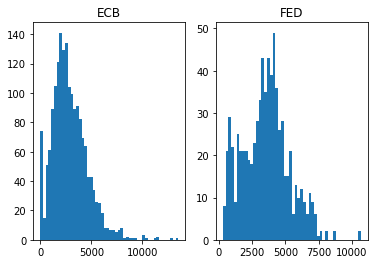

In [ ]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

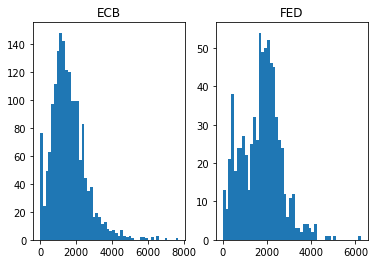

In [ ]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

In [ ]:
#np.where(np.array(lenght_texts_ecb).astype('int64')<200)

# Categorical Variable: Speakers

In [ ]:
df_fed.speaker.value_counts()

Chairman Ben S. Bernanke                        145
Governor Lael Brainard                           68
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Stanley Fischer                    45
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chairman Donald L. Kohn                     41
Vice Chair for Supervision Randal K. Quarles     39
Governor Randall S. Kroszner                     36
Chairman Jerome H. Powell                        32
Governor Frederic S. Mishkin                     26
Vice Chairman Richard H. Clarida                 26
Vice Chair Janet L. Yellen                       22
Governor Sarah Bloom Raskin                      17
Governor Kevin Warsh                             16
Governor Jeremy C. Stein                         16
Governor Michelle W. Bowman                      13
Governor Susan S. Bies                            3
Name: speake

In [ ]:
df_ecb.speaker = categorical_other(df_ecb.speaker)
df_fed.speaker = categorical_other(df_fed.speaker, threshold=0.025)

# Text Concatenation

In [ ]:
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]"
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261]


In [ ]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [ ]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]


# Removal Zero value Time series

Probably due to a score approximation 

Some times all indices are null

In [ ]:
df_train_series.loc[df_train_series['Index + 1']==0.0]['Index Name'].value_counts()

SRVIX Index         428
CVIX Index           70
MOVE Index           50
VIX Index            41
V2X Index            36
SPX Index            36
SX5E Index           25
EURUSDV1M Curncy     13
EURUSD Curncy         7
Name: Index Name, dtype: int64

In [ ]:
sup = df_train_series.loc[df_train_series['Index + 1']==0.0].index
df_train_series.drop(sup,inplace=True)
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]


In [ ]:
#df_train_series.to_csv("./data/train_series_clean_no_0.csv")

In [ ]:
df_train_series.columns 

Index(['id_series', 'Index Name', 'Index - 9', 'Index - 8', 'Index - 7',
       'Index - 6', 'Index - 5', 'Index - 4', 'Index - 3', 'Index - 2',
       'Index - 1', 'Index - 0', 'Index + 1', 'id_ecb', 'id_fed',
       'text_concat_ecb', 'list_speakers_ecb', 'text_concat_fed',
       'list_speakers_fed'],
      dtype='object')

# Tokenisation


On va désormais procéder à l'étape de tokenisation de notre texte. La tokenization permet de transformer le texte brut en une liste de tokens, qui peuvent être analysés par la suite lors de l'analyse des sentiments. En divisant le texte en unités de sens plus petites, la tokenization permet également de réduire la complexité du texte et de faciliter son analyse.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Création d'une fonction de tokenisation
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Appliquer la fonction de tokenisation à chaque ligne de la colonne "
df_train_series['text_concat_ecb_tokenisé'] = df_train_series['text_concat_ecb'].apply(tokenize_text)
df_train_series['text_concat_fed_tokenisé'] = df_train_series['text_concat_fed'].apply(tokenize_text)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_train_series['text_concat_fed_tokenisé'].head()

0    [delighted, helsinki, important, conference, m...
1    [watch, live, would, like, thank, federal, res...
2    [grateful, national, association, business, ec...
3    [thank, invitation, speak, today, begin, take,...
4    [year, symposium, topic, challenge, monetary, ...
Name: text_concat_fed_tokenisé, dtype: object

In [ ]:
# On crée une nouvelle colonne appelé 'V_Cible_categ', rendant catégorielle notre variable cible (pour la classification)

df_train_series['V_Cible_categ'] = df_train_series['Index + 1'].apply(lambda x: 'Hausse' if x > 0 else 'Baisse')
df_train_series['V_Cible_categ']

0       Hausse
1       Hausse
2       Hausse
3       Hausse
4       Hausse
         ...  
8941    Baisse
8942    Baisse
8943    Hausse
8944    Baisse
8945    Hausse
Name: V_Cible_categ, Length: 8240, dtype: object

# Sentiment Analysis


## TextBlob

Tout d'abord, rappelons qu'il est important de réaliser l'analyse de sentiment avec des algorithmes différents, afin de déterminer lequel est le plus adapté à nos données.
Nous faisons ici l'analyse de sentiment avec TextBlob et Vader, les deux algorithmes les plus connus et utilisés, mais qui ne sont pas particulièrement adaptés à la finance

1/ Analyse de sentiment avec TextBlob

In [ ]:
from textblob import TextBlob


# Ajouter une colonne pour le score de polarité
df_train_series['polarity_score_ecb_TB'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
df_train_series['polarity_score_fed_TB'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

# Ajouter une colonne pour le score de subjectivité
df_train_series['subjectivity_score_ecb_TB'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
df_train_series['subjectivity_score_fed_TB'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)


In [ ]:
# Ajouter une colonne pour l'étiquetage des sentiments


df_train_series['sentiment_label_ecb_TB'] = df_train_series['polarity_score_ecb_TB'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
df_train_series['sentiment_label_fed_TB'] = df_train_series['polarity_score_fed_TB'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')

def ma_fonction(a, b):
  if a+b > 0.1:
    return 'positive'
  elif a+b< 0.1:
    return 'negative'
  else:
    return 'neutral'
 


df_train_series['sentiment_label_TB'] = df_train_series.apply(lambda row: ma_fonction(row['polarity_score_ecb_TB'],row['polarity_score_fed_TB']),axis=1)


On fait la somme des scores de polarités de fed et ecb. On associe l'étiquette 'positive' si le score de polarité est >0.1, 'négative' si <-0.1 et 'neutral' sinon.

In [ ]:
df_train_series.head(7)

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,...,text_concat_ecb_tokenisé,text_concat_fed_tokenisé,V_Cible_categ,polarity_score_ecb_TB,polarity_score_fed_TB,sentiment_label_ecb_TB,sentiment_label_fed_TB,subjectivity_score_ecb_TB,subjectivity_score_fed_TB,sentiment_label_TB
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,...,"[welcome, address, welcome, remark, philip, r,...","[delighted, helsinki, important, conference, m...",Hausse,0.058804,0.083488,neutral,neutral,0.333255,0.406072,positive
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,...,"[monetary, policy, structural, reform, euro, a...","[watch, live, would, like, thank, federal, res...",Hausse,0.075094,0.064017,neutral,neutral,0.442873,0.388628,positive
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,...,"[challenge, opportunity, reboot, european, fin...","[grateful, national, association, business, ec...",Hausse,0.075828,0.065152,neutral,neutral,0.374899,0.417488,positive
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,...,"[create, stability, uncertain, world, speech, ...","[thank, invitation, speak, today, begin, take,...",Hausse,0.085738,0.076183,neutral,neutral,0.393368,0.393578,positive
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,...,"[money, private, currency, reflection, libra, ...","[year, symposium, topic, challenge, monetary, ...",Hausse,0.061226,0.124564,neutral,positive,0.342816,0.396657,positive
5,5,SPX Index,0.001815,-0.003185,-0.011381,-0.003778,-0.000101,0.006300,-0.003106,0.016511,...,"[hear, committee, economic, monetary, affair, ...","[paul, alan, disadvantage, u, ask, reflect, te...",Hausse,0.070573,0.078779,neutral,neutral,0.378880,0.414213,positive
7,7,CVIX Index,-0.035118,0.006281,0.001287,0.007914,-0.031893,-0.018767,-0.009505,-0.010522,...,"[international, monetary, system, towards, new...","[delighted, participate, brimmer, policy, foru...",Baisse,0.074694,0.049604,neutral,neutral,0.344159,0.374191,positive


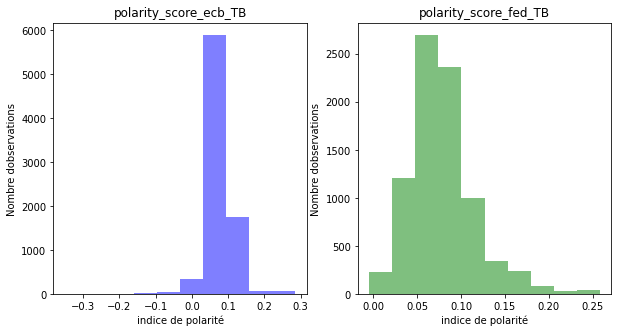

In [ ]:
# On trace une représentation graphique de la répartition des scores de polarité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['polarity_score_ecb_TB'], color='blue', alpha=0.5)
ax1.set(title='polarity_score_ecb_TB', xlabel='indice de polarité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['polarity_score_fed_TB'], color='green', alpha=0.5)
ax2.set(title='polarity_score_fed_TB', xlabel='indice de polarité', ylabel='Nombre dobservations')

plt.show()

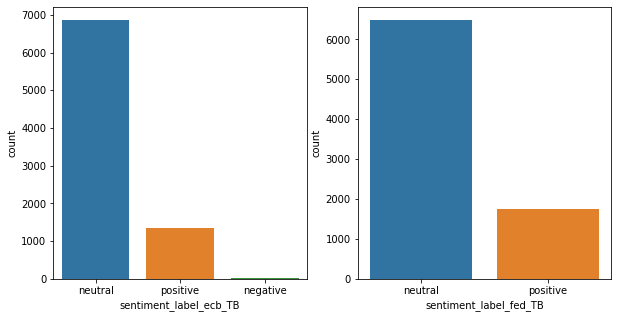

In [ ]:
# On trace une représentation graphique de la répartition des labels


import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

sns.countplot(x='sentiment_label_ecb_TB', data=df_train_series, ax=axs[0])
sns.countplot(x='sentiment_label_fed_TB', data=df_train_series, ax=axs[1])

plt.show()

Comme on peut le voir, la méthode TextBlob est peu efficace. Une grande majorité des textes sont étiquetté "neutral".
Quasiment aucun texte n'est étiqueté "négatif"

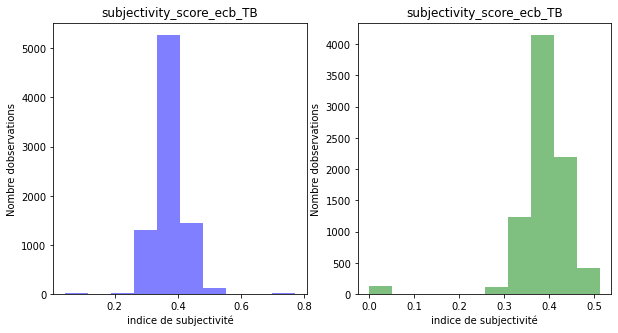

In [ ]:
# On trace une représentation graphique de la répartition des scores de subjectivité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['subjectivity_score_ecb_TB'], color='blue', alpha=0.5)
ax1.set(title='subjectivity_score_ecb_TB', xlabel='indice de subjectivité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['subjectivity_score_fed_TB'], color='green', alpha=0.5)
ax2.set(title='subjectivity_score_ecb_TB', xlabel='indice de subjectivité', ylabel='Nombre dobservations')

plt.show()


On effectue maintenant une analyse de la corrélation entre 'sentiment_label_TB' et 'V_Cible_categ'

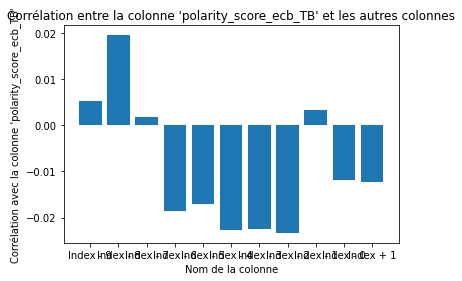

In [ ]:
# Analyse de la corrélation entre chacun des indices et 'V_Cible_categ'


#On crée un nouveau tableau ne contenant que les indices

df_indice = df_train_series.loc[:, ["Index - 9", "Index - 8", "Index - 7","Index - 6", "Index - 5", "Index - 4","Index - 3", "Index - 2", "Index - 1","Index - 0","Index + 1"]]
df_indice.head()

# Sélectionner la colonne à analyser
col1 = df_train_series['sentiment_label_TB']

# Calculer la corrélation avec les autres colonnes
corr = df_indice.corrwith(df_train_series['polarity_score_ecb_TB'])

# Créer un graphique en barres
plt.bar(corr.index, corr.values)

# Ajouter une légende et un titre
plt.xlabel("Nom de la colonne")
plt.ylabel("Corrélation avec la colonne 'polarity_score_ecb_TB'")
plt.title("Corrélation entre la colonne 'polarity_score_ecb_TB' et les autres colonnes")

# Afficher le graphique
plt.show()

In [ ]:
#On trace les différentes matrice de confusion

tableau_croise_ecb = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_ecb_TB'])
tableau_croise_fed = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_fed_TB'])
tableau_croise = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_TB'])

print('La matrice de confusion pour ecb est:')
print(tableau_croise_ecb)

print('La matrice de confusion pour fed est:')
print(tableau_croise_fed)

print('La matrice de confusion pour notre sentiment final est:')
print(tableau_croise)

La matrice de confusion pour ecb est:
sentiment_label_ecb_TB  negative  neutral  positive
V_Cible_categ                                      
Baisse                        17     3497       710
Hausse                        15     3364       637
La matrice de confusion pour fed est:
sentiment_label_fed_TB  neutral  positive
V_Cible_categ                            
Baisse                     3329       895
Hausse                     3156       860
La matrice de confusion pour notre sentiment final est:
sentiment_label_TB  negative  positive
V_Cible_categ                         
Baisse                   525      3699
Hausse                   479      3537


Comme on peut le voir, la corrélation est inexistante. En gros l'analyse de sentiment ne sert à rien.

## Vader

2/ On fait l'analyse de sentiment avec Vader

In [ ]:
# import des bibliothèques nécessaires
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# instantiation de l'analyseur de sentiment VADER
vader = SentimentIntensityAnalyzer()

# définition d'une fonction pour obtenir le score de polarité de sentiment en utilisant VADER
def get_sentiment_score(text):
    return vader.polarity_scores(text)['compound']

# ajout de colonnes pour le score de polarité
df_train_series['polarity_score_ecb_Vader'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))
df_train_series['polarity_score_fed_Vader'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))

# ajout de colonnes pour l'étiquetage des sentiments
df_train_series['sentiment_label_ecb_Vader'] = df_train_series['polarity_score_ecb_Vader'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
df_train_series['sentiment_label_fed_Vader'] = df_train_series['polarity_score_fed_Vader'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# ajout de colonnes pour l'étiquetage des sentiments
df_train_series['sentiment_label_ecb_Vader'] = df_train_series['polarity_score_ecb_Vader'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')
df_train_series['sentiment_label_fed_Vader'] = df_train_series['polarity_score_fed_Vader'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')

def ma_fonction(a, b):
  if a+b > 0.1:
    return 'positive'
  elif a+b< 0.1:
    return 'negative'
  else:
    return 'neutral'
 


df_train_series['sentiment_label_Vader'] = df_train_series.apply(lambda row: ma_fonction(row['polarity_score_ecb_Vader'],row['polarity_score_fed_Vader']),axis=1)


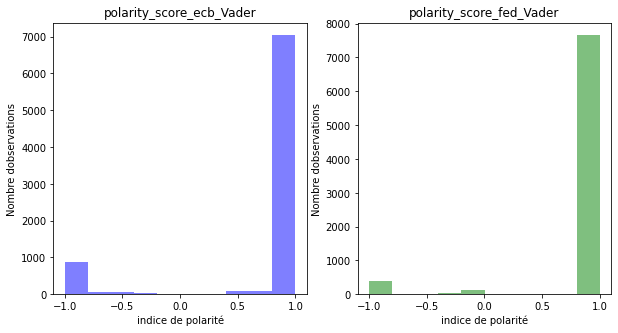

In [ ]:
# On trace une représentation graphique de la répartition des scores de polarité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['polarity_score_ecb_Vader'], color='blue', alpha=0.5)
ax1.set(title='polarity_score_ecb_Vader', xlabel='indice de polarité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['polarity_score_fed_Vader'], color='green', alpha=0.5)
ax2.set(title='polarity_score_fed_Vader', xlabel='indice de polarité', ylabel='Nombre dobservations')

plt.show()

Les scores de polarités sont beaucoup plus polarisés

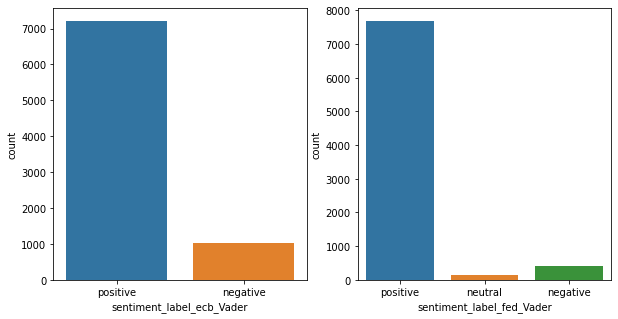

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# On trace une représentation graphique de la répartition des labels

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

sns.countplot(x='sentiment_label_ecb_Vader', data=df_train_series, ax=axs[0])
sns.countplot(x='sentiment_label_fed_Vader', data=df_train_series, ax=axs[1])

plt.show()

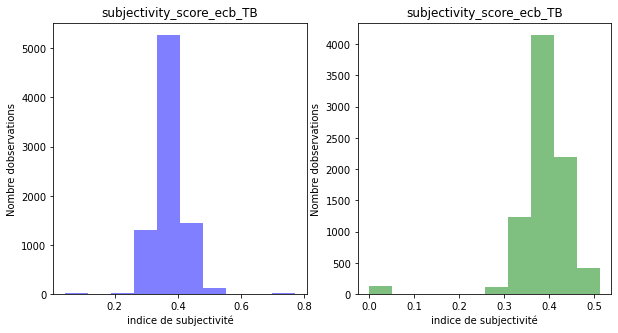

In [ ]:
# Analyse de la corrélation

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['subjectivity_score_ecb_TB'], color='blue', alpha=0.5)
ax1.set(title='subjectivity_score_ecb_TB', xlabel='indice de subjectivité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['subjectivity_score_fed_TB'], color='green', alpha=0.5)
ax2.set(title='subjectivity_score_ecb_TB', xlabel='indice de subjectivité', ylabel='Nombre dobservations')

plt.show()

In [ ]:
# Analyse de la corrélation

import pandas as pd




# Créer une table de contingence
table_ecb = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_ecb_Vader'])
print(table_ecb)
table_fed = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_fed_Vader'])
print(table_fed)
table= pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_Vader'])
print(table)


sentiment_label_ecb_Vader  negative  positive
V_Cible_categ                                
Baisse                          529      3695
Hausse                          502      3514
sentiment_label_fed_Vader  negative  neutral  positive
V_Cible_categ                                         
Baisse                          224       78      3922
Hausse                          201       56      3759
sentiment_label_Vader  negative  positive
V_Cible_categ                            
Baisse                      627      3597
Hausse                      581      3435


On voit ici aussi que lanalyse de sentiments ne nous donne pas de résultats pertinents.

Désormais, nous allons réaliser notre analyse de sentiments avec HIV4 et LLoughan and McDonald, deux languages adaptés à la finance.

## HIV4

In [ ]:
# Analyse de sentiment avec des lexiques financiers

!pip install pysentiment2

import pysentiment2 as ps
hiv4 = ps.HIV4()


def get_sentiment_score(text):
    tokens = hiv4.tokenize(text)                                 
    score = hiv4.get_score(tokens)
    return score

# ajout de colonnes pour le score de polarité
df_train_series['polarity_score_ecb_Harvard'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))
df_train_series['polarity_score_fed_Harvard'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 397, in run
    conflicts = self._determine_conflicts(to_inst

KeyboardInterrupt: ignored

In [ ]:
# On affiche unniquement la polarité

df_train_series['polarity_fed_Harvard'] = df_train_series['polarity_score_fed_Harvard'].apply(lambda x: x['Polarity'])
df_train_series['polarity_ecb_Harvard'] = df_train_series['polarity_score_ecb_Harvard'].apply(lambda x: x['Polarity'])



In [ ]:
# ajout de colonnes pour l'étiquetage des sentiments
df_train_series['sentiment_label_ecb_Harvard'] = df_train_series['polarity_ecb_Harvard'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
df_train_series['sentiment_label_fed_Harvard'] = df_train_series['polarity_fed_Harvard'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
def ma_fonction(a, b):
  if a+b > 0.1:
    return 'positive'
  elif a+b< 0.1:
    return 'negative'
  else:
    return 'neutral'
 


df_train_series['sentiment_label_Harvard'] = df_train_series.apply(lambda row: ma_fonction(row['polarity_ecb_Harvard'],row['polarity_fed_Harvard']),axis=1)



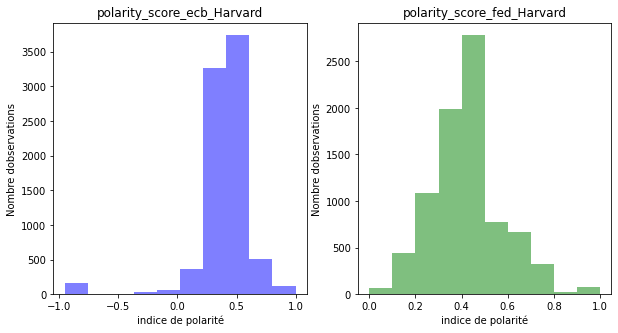

In [ ]:
# On trace une représentation graphique de la répartition des scores de polarité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['polarity_ecb_Harvard'], color='blue', alpha=0.5)
ax1.set(title='polarity_score_ecb_Harvard', xlabel='indice de polarité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['polarity_fed_Harvard'], color='green', alpha=0.5)
ax2.set(title='polarity_score_fed_Harvard', xlabel='indice de polarité', ylabel='Nombre dobservations')

plt.show()

In [ ]:
# Matrice de confusion

table_fed = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_fed_Harvard'])
print(table_fed)
table_ecb = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_ecb_Harvard'])
print(table_ecb)
table = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_Harvard'])
print(table)



sentiment_label_fed_Harvard  neutral  positive
V_Cible_categ                                 
Baisse                            37      4187
Hausse                            34      3982
sentiment_label_ecb_Harvard  negative  neutral  positive
V_Cible_categ                                           
Baisse                            111       74      4039
Hausse                             94       85      3837
sentiment_label_Harvard  negative  positive
V_Cible_categ                              
Baisse                         95      4129
Hausse                         78      3938


ca n'a pas l'air très pertinent non plus

## Loughan and McDonald

In [ ]:
# Loughan and McDonald Dictionnary

import pysentiment2 as ps
lm = ps.LM()
def get_sentiment_score(text):
  tokens = lm.tokenize(text)
  score = lm.get_score(tokens)
  return score


# ajout de colonnes pour le score de polarité
df_train_series['polarity_score_ecb_LM'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))
df_train_series['polarity_score_fed_LM'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))



In [ ]:
df_train_series['polarity_score_fed_LM']

0       {'Positive': 57, 'Negative': 84, 'Polarity': -...
1       {'Positive': 40, 'Negative': 96, 'Polarity': -...
2       {'Positive': 114, 'Negative': 255, 'Polarity':...
3       {'Positive': 71, 'Negative': 132, 'Polarity': ...
4       {'Positive': 69, 'Negative': 140, 'Polarity': ...
                              ...                        
8941    {'Positive': 60, 'Negative': 170, 'Polarity': ...
8942    {'Positive': 100, 'Negative': 198, 'Polarity':...
8943    {'Positive': 83, 'Negative': 158, 'Polarity': ...
8944    {'Positive': 127, 'Negative': 252, 'Polarity':...
8945    {'Positive': 8, 'Negative': 22, 'Polarity': -0...
Name: polarity_score_fed_LM, Length: 8240, dtype: object

In [ ]:
df_train_series['polarity_fed_LM'] = df_train_series['polarity_score_fed_LM'].apply(lambda x: x['Polarity'])
df_train_series['polarity_ecb_LM'] = df_train_series['polarity_score_ecb_LM'].apply(lambda x: x['Polarity'])
df_train_series['polarity_ecb_LM'].head()

0   -0.079545
1    0.019608
2   -0.213675
3    0.000000
4   -0.264368
Name: polarity_ecb_LM, dtype: float64

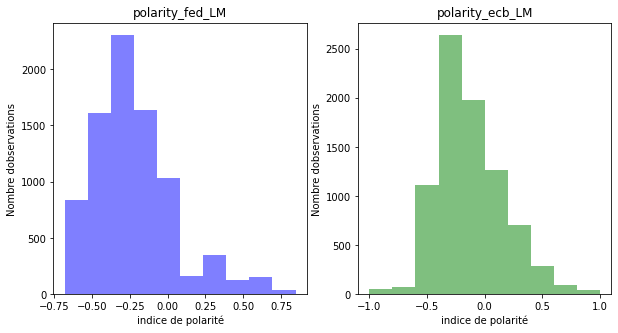

In [ ]:
# On trace une représentation graphique de la répartition des scores de polarité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['polarity_fed_LM'], color='blue', alpha=0.5)
ax1.set(title='polarity_fed_LM', xlabel='indice de polarité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['polarity_ecb_LM'], color='green', alpha=0.5)
ax2.set(title='polarity_ecb_LM', xlabel='indice de polarité', ylabel='Nombre dobservations')

plt.show()

In [ ]:
# ajout de colonnes pour l'étiquetage des sentiments
df_train_series['sentiment_label_ecb_LM'] = df_train_series['polarity_ecb_LM'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
df_train_series['sentiment_label_fed_LM'] = df_train_series['polarity_fed_LM'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
def ma_fonction(a, b):
  if a+b > 0.1:
    return 'positive'
  elif a+b< 0.1:
    return 'negative'
  else:
    return 'neutral'
 


df_train_series['sentiment_label_LM'] = df_train_series.apply(lambda row: ma_fonction(row['polarity_ecb_LM'],row['polarity_fed_LM']),axis=1)



In [ ]:
df_train_series['sentiment_label_LM'].value_counts()

negative    6634
positive    1606
Name: sentiment_label_LM, dtype: int64

In [ ]:
# Matrice de confusion
print('Matrice de confusion pour text fed')
table_fed = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_ecb_LM'])
print(table_fed)
print('Matrice de confusion pour text ecb')
table_ecb = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_fed_LM'])
print(table_ecb)
print('Matrice de confusion pour text ecb+fed')
table = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_LM'])
print(table)

Matrice de confusion pour text fed
sentiment_label_ecb_LM  negative  neutral  positive
V_Cible_categ                                      
Baisse                      2421     1032       771
Hausse                      2293     1023       700
Matrice de confusion pour text ecb
sentiment_label_fed_LM  negative  neutral  positive
V_Cible_categ                                      
Baisse                      3199      625       400
Hausse                      3017      587       412
Matrice de confusion pour text ecb+fed
sentiment_label_LM  negative  positive
V_Cible_categ                         
Baisse                  3716       508
Hausse                  3476       540


On voit clairement que l'analyse des sentiment est efficace ici ! Un texte étiqueté 'positive' aura tendance à être associé à une hausse la ou un texte étiqueté 'négative' aura tendance à être associé à une baisse.

# Train Test Split

In [ ]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=df_train_series[["Index + 1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

Binary Classification

In [ ]:
y_t = np.sign(y_train)
y_t.value_counts()

In [ ]:
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

# Categorical Encoding 

In [ ]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]
test_conc = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
test_conc.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)
enc = WOEEncoder(cols=col_speakers)
tr = enc.fit_transform(test_conc, y_t)
tr.fillna(0,inplace=True)

In [ ]:
tr.head()

# Embeddings

## Build a vocabulary

## Create the co-occurence Matrix

## Embeddings from the co-occurence Matrix

### SVD

## Sentence Representations

# Save Data